In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pathlib
import scipy.io as sio
from os.path import dirname, join as pjoin
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
import imageio
from PIL import Image
from random import randint
import scipy
from sklearn.preprocessing import RobustScaler

In [37]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [38]:
from whitening import whiten
import matplotlib.image as mpimg
import PIL.Image
import cv2
from skimage import io, color
from resizeimage import resizeimage
from tqdm.auto import tqdm

In [39]:
print(tf.__version__)

2.2.0


In [40]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [41]:
nombre_image_train = 0
nombre_image_test = 0

# Creation des dossiers images du train et du set

In [42]:
if not os.path.exists('train'):
    os.makedirs('train')
if not os.path.exists('test'):
    os.makedirs('test')


for repertoir in os.listdir('Images'):
    if not os.path.exists('train/'+repertoir):
        os.makedirs('train/'+repertoir)
    if not os.path.exists('test/'+repertoir):
        os.makedirs('test/'+repertoir)

    tmp_data = os.listdir(pathlib.Path().joinpath('Images/'+repertoir).absolute())
    x_train, x_test = train_test_split(tmp_data, test_size = 0.2)

    for img1 in x_train:
        nombre_image_train = nombre_image_train + 1
        copyfile(pathlib.Path().joinpath('Images/'+repertoir+'/'+img1).absolute(), pathlib.Path().joinpath('train/'+repertoir+'/'+img1).absolute())

    for img2 in x_test:
        nombre_image_test = nombre_image_test + 1
        copyfile(pathlib.Path().joinpath('Images/'+repertoir+'/'+img2).absolute(), pathlib.Path().joinpath('test/'+repertoir+'/'+img2).absolute())


In [43]:
print(nombre_image_train)
print(nombre_image_test)

1531
388


In [34]:
nombre_image_train = 1531
nombre_image_test = 388

# Traitement des images

## Resize

In [45]:
directory_train = 'test/' 
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        img = os.path.join(subdir, file)
        with open(img, 'r+b') as f:
            with Image.open(f) as image:
                if(image.size > (150,150,3)):
                    cover = resizeimage.resize_cover(image, (150, 150))
                    cover.save(img, image.format)
                pbar.update(1/nombre_image_test)
pbar.close()
                
directory_train = 'train/'  
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        img = os.path.join(subdir, file)
        with open(img, 'r+b') as f:
            with Image.open(f) as image:
                if(image.size > (150,150,3)):
                    cover = resizeimage.resize_cover(image, (150, 150))
                    cover.save(img, image.format)
                pbar.update(1/nombre_image_train)
pbar.close()

# Normalisation des images

In [66]:
directory_train = 'test/' 
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        img = os.path.join(subdir, file)
        image = cv2.imread(img,cv2.IMREAD_COLOR)
        norm = cv2.normalize(image,None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        pbar.update(1/nombre_image_test)
pbar.close()
                
directory_train = 'train/'  
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        img = os.path.join(subdir, file)
        image = cv2.imread(img,cv2.IMREAD_COLOR)
        norm = cv2.normalize(image,None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        pbar.update(1/nombre_image_train)
pbar.close()


[[[0.34552845 0.36991867 0.41463414]
  [0.35365853 0.37804878 0.4227642 ]
  [0.35365853 0.3902439  0.42682925]
  ...
  [0.13821137 0.14227642 0.18292682]
  [0.13414633 0.13821137 0.17886178]
  [0.13414633 0.13821137 0.17886178]]

 [[0.3617886  0.38617885 0.4308943 ]
  [0.34552845 0.3821138  0.4227642 ]
  [0.33739835 0.37398374 0.41463414]
  ...
  [0.1504065  0.15447155 0.19512194]
  [0.14634146 0.1504065  0.1910569 ]
  [0.14227642 0.14634146 0.18699187]]

 [[0.3495935  0.3821138  0.43495932]
  [0.3617886  0.39837396 0.4390244 ]
  [0.37398374 0.4105691  0.4512195 ]
  ...
  [0.1504065  0.15447155 0.19512194]
  [0.14634146 0.1504065  0.1910569 ]
  [0.14227642 0.14634146 0.18699187]]

 ...

 [[0.06910568 0.0406504  0.33739835]
  [0.06504065 0.03658536 0.3333333 ]
  [0.06504065 0.03658536 0.3414634 ]
  ...
  [0.07317073 0.03252032 0.3414634 ]
  [0.07723577 0.03658536 0.34552845]
  [0.08130081 0.0406504  0.3495935 ]]

 [[0.06910568 0.0406504  0.34552845]
  [0.06910568 0.0406504  0.34552845]

## Whitening

In [67]:
def whitening(img):
    image = PIL.Image.open(img)
    foreground, background = whiten(image, kernel_size=20, downsample=4)
    foreground.save(img, 'jpeg')
                                    
# image = plt.show('Images/n02085620-Chihuahua/'+tmp_data[0])
# foreground, background = whiten(image, kernel_size=20, downsample=4)
# foreground.save('foreground.jpg', 'jpeg')

# On s'occupe des images dans train  
directory_train = 'train/' 
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        a = os.path.join(subdir, file)
        whitening(a)
        pbar.update(1/nombre_image_train)
pbar.close()
    
# On s'occupe des images dans test
directory_test= 'test/'
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_test):
    for file in files:
        a = os.path.join(subdir, file)
        whitening(a)
        pbar.update(1/nombre_image_test)
pbar.close()

## Equalization

In [68]:
def equalization(image):
    img = cv2.imread(image)
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    cv2.imwrite(image,hist_equalization_result)
    
    
directory_train = 'train/'
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        a = os.path.join(subdir, file)
        equalization(a)
        pbar.update(1/nombre_image_train)
pbar.close()

directory_train = 'test/'
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        a = os.path.join(subdir, file)
        equalization(a)
        pbar.update(1/nombre_image_test)
pbar.close()

# Augmention du train

In [69]:
def reName(imgName, endString, idString):
    index = imgName.find(endString)
    if index != -1 :
        newImageName = imgName[0:(index-1)]
        newImageName = newImageName + idString + endString
        return newImageName
    else:
        return imgName

## Mirroring

In [70]:
def mirror(img):
    image = cv2.imread(img)
    mirrorImage = cv2.flip(image, 1)
    newImgName = reName(img, '.jpg', '_m')
    mirrorImage = Image.fromarray(mirrorImage)
    mirrorImage.save(newImgName , 'jpeg')

## Cropping

In [71]:
def zoom(img):
    image = cv2.imread(img)
    h, w = image.shape[:2]
    zoomImg = image[h//8 : -h//8,w//8 : -w//8]
    newImgName = reName(img, '.jpg', '_z')
    zoomImg = Image.fromarray(zoomImg)
    zoomImg.save(newImgName , 'jpeg')

## Rotate

In [72]:
def rotate(img):
    value = randint(-90, 90)
    image = Image.open(img)
    image = image.rotate(value)
    newImgName = reName(img, '.jpg', '_r')
    image.save(newImgName , 'jpeg')

In [73]:
# On s'occupe des images dans train    
directory_train = 'train/' 
pbar = tqdm(total=1)
for subdir, dirs, files in os.walk(directory_train):
    for file in files:
        if file.find('_r') != -1 or file.find('_z') != -1 or file.find('_m') != -1:
            continue
        else:
            a = os.path.join(subdir, file)
            rotate(a)
            zoom(a)
            mirror(a)
            pbar.update(1/nombre_image_train)
pbar.close()

In [74]:
img = mpimg.imread(pathlib.Path().joinpath('Train\\Afghan_hound\\n02088094_1406.jpg').absolute())
print(norm)

[[[0.34552845 0.36991867 0.41463414]
  [0.35365853 0.37804878 0.4227642 ]
  [0.35365853 0.3902439  0.42682925]
  ...
  [0.13821137 0.14227642 0.18292682]
  [0.13414633 0.13821137 0.17886178]
  [0.13414633 0.13821137 0.17886178]]

 [[0.3617886  0.38617885 0.4308943 ]
  [0.34552845 0.3821138  0.4227642 ]
  [0.33739835 0.37398374 0.41463414]
  ...
  [0.1504065  0.15447155 0.19512194]
  [0.14634146 0.1504065  0.1910569 ]
  [0.14227642 0.14634146 0.18699187]]

 [[0.3495935  0.3821138  0.43495932]
  [0.3617886  0.39837396 0.4390244 ]
  [0.37398374 0.4105691  0.4512195 ]
  ...
  [0.1504065  0.15447155 0.19512194]
  [0.14634146 0.1504065  0.1910569 ]
  [0.14227642 0.14634146 0.18699187]]

 ...

 [[0.06910568 0.0406504  0.33739835]
  [0.06504065 0.03658536 0.3333333 ]
  [0.06504065 0.03658536 0.3414634 ]
  ...
  [0.07317073 0.03252032 0.3414634 ]
  [0.07723577 0.03658536 0.34552845]
  [0.08130081 0.0406504  0.3495935 ]]

 [[0.06910568 0.0406504  0.34552845]
  [0.06910568 0.0406504  0.34552845]


# Recuperation du train et du set

In [75]:
training_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [76]:
train = training_data.flow_from_directory(
    pathlib.Path().joinpath('Train').absolute(),
    target_size=(150,150),
    class_mode='categorical'
)

test = training_data.flow_from_directory(
    pathlib.Path().joinpath('test').absolute(),
    target_size=(150,150),
    class_mode='categorical'
)

Found 5764 images belonging to 10 classes.
Found 388 images belonging to 10 classes.


# Model

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(700, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(300, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [78]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Entrainement du model

In [ ]:
history = model.fit(train,
                    epochs=40,
                   validation_data=train, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                               tfdocs.modeling.EpochDots(),
                               tf.keras.callbacks.ModelCheckpoint("weights.best.hdf5", 
                                                                   monitor='val_accuracy', 
                                                                   verbose=0, 
                                                                   save_best_only=True, 
                                                                   save_weights_only=False, 
                                                                   mode='max', 
                                                                   periode=1)])

Epoch 1/40
  7/181 [>.............................] - ETA: 1:53 - loss: 3.8314 - accuracy: 0.1295

# Sauvegarde du model

In [9]:
model.save('snooky.h5')

# matrice de confusion

In [11]:
from sklearn.metrics import confusion_matrix

In [32]:

e = [0 for x in range(0,48)]
f = [1 for x in range(0,38)]
g = [2 for x in range(0,31)]
h = [3 for x in range(0,37)]
i = [4 for x in range(0,51)]
j = [5 for x in range(0,40)]
k = [6 for x in range(0,30)]
l = [7 for x in range(0,35)]
m = [8 for x in range(0,43)]
n = [9 for x in range(0,35)]
z =e+f+g+h+i+j+k+l+m+n
print(z)
confusion_matrix( z,model.predict(test))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

# Evaluation

In [8]:
test_loss, test_acc = model.evaluate(test)

13/13 [==============================] - 2s 147ms/step - loss: 3.1544 - accuracy: 0.3686


# Load du  Model

In [4]:
model = tf.keras.models.load_model('snooky.h5')

# Courbe d'apprentissage

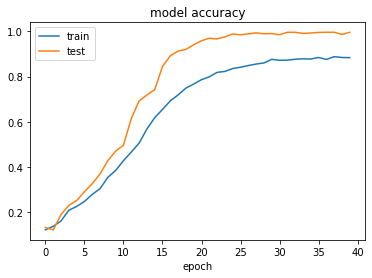

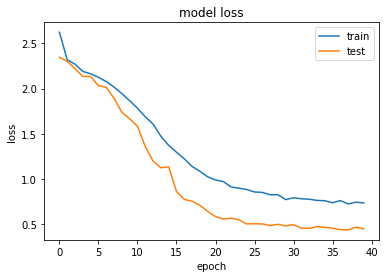

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="test")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Prediction

Found 1 images belonging to 1 classes.


([<matplotlib.axis.XTick at 0x1dcbcd7df70>,
 [Text(0, 0, 'Afghan_hound'),
  Text(0, 0, 'Blenheim_spaniel'),
  Text(0, 0, 'Chihuahua'),
  Text(0, 0, 'Japanese_spaniel'),
  Text(0, 0, 'Maltese_dog'),
  Text(0, 0, 'papillon'),
  Text(0, 0, 'Pekinese'),
  Text(0, 0, 'Rhodesian_ridgeback'),
  Text(0, 0, 'Shih-Tzu'),
  Text(0, 0, 'toy_terrier')])

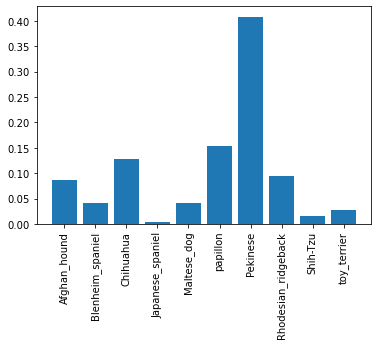

In [12]:
class_names =[ 'Afghan_hound', 'Blenheim_spaniel', 'Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'papillon', 'Pekinese', 'Rhodesian_ridgeback', 'Shih-Tzu',  'toy_terrier']

            
test_user = training_data.flow_from_directory(
    pathlib.Path().joinpath('test_user').absolute(),
    target_size=(150,150),
    class_mode='categorical'
)
prediction = model.predict(test_user)

plt.bar(range(10),prediction[0])
plt.xticks(range(10), class_names, rotation=90)